In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction
from reservoir_tools.load_preserving_sign import load_preserving_signs

# Whole graph

In [6]:
graph=load_preserving_signs("reservoir_tools/red_simplificada.txt")
H = graph.copy()
G2 = H.to_undirected()
Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
k2 = graph.subgraph(Gcc[0])

## Whole graph - number of genes

In [11]:
arrows = graph.number_of_edges()
noodes = graph.number_of_nodes()
print("The number of nodes of the whole graph is %d and the number of edges is %d"%(noodes, arrows))

The number of nodes of the whole graph is 3243 and the number of edges is 8373


## Giant component of whole graph - number of genes

In [12]:
arrows = k2.number_of_edges()
noodes = k2.number_of_nodes()
print("The number of nodes of the giant component of the whole graph is %d and the number of edges is %d"%(noodes, arrows))

The number of nodes of the giant component of the whole graph is 3236 and the number of edges is 8366


## We consider the giant component of the whole graph

## Network motifs in the whole graph

In [13]:
import networkx.algorithms.isomorphism as iso

def find_pattern(graph, pattern, sign_sensitive=False):
    """Find all the subgraphs isomorphic to the given pattern.

    Return an iterator over all the subgraphs in `graph` that are isomorphic to
    the specified `pattern`. It works for both directed and undirected graphs,
    but the type of `graph` and `pattern` arguments must be coherent.
    If `sign_sensitive` is False, only the topology is considered for the
    isomorphism test. Otherwise, the "sign" attribute of each edge must have
    the same value.

    Based on the code from
    https://zulko.wordpress.com/2012/10/13/finding-a-subnetwork-with-a-given-topology-in-e-coli/
    """
    edge_match = None
    if sign_sensitive:
        def edge_match(e1, e2):
            #return (e1["sign"] == e2["sign"])
            return (e1["weight"] == e2["weight"])

    if graph.is_directed() and pattern.is_directed():
        matcher = iso.DiGraphMatcher(graph, pattern, edge_match=edge_match)
    elif not graph.is_directed() and not pattern.is_directed():
        matcher = iso.GraphMatcher(graph, pattern, edge_match=edge_match)
    else:
        raise TypeError("type of `graph` and `pattern` arguments is not "
                        "coherent!")

    return matcher.subgraph_isomorphisms_iter()

In [47]:
# to look for network motifs it is necessary to remove self-loops
k2_copy = k2.copy()
k2_copy.remove_edges_from(nx.selfloop_edges(k2_copy))

def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

drop_weights(k2_copy)

## FFL motif

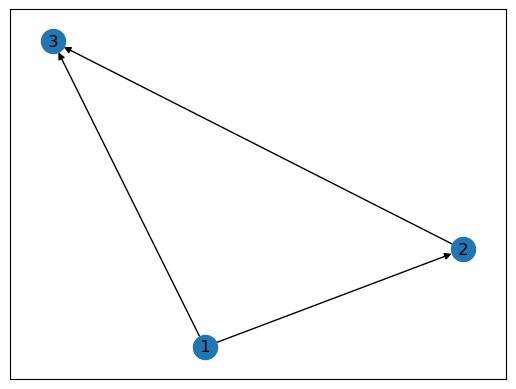

In [16]:
FFL = nx.DiGraph()
FFL.add_edge(1,2)
FFL.add_edge(2,3)
FFL.add_edge(1,3)
nx.draw_networkx(FFL , with_labels=True)

In [22]:
real_ffl = find_pattern(k2_copy,FFL)
iffl = 0
for module in real_ffl:
    iffl = iffl+1
    #print(module)
print("The number of FFL in the whole graph is %d"%(iffl))


The number of FFL in the whole graph is 4798


## Mutual regulation motif

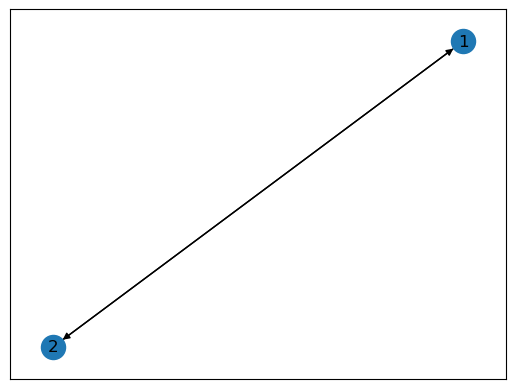

In [23]:
feedback_two = nx.DiGraph()
feedback_two.add_edge(1,2)
feedback_two.add_edge(2,1)
nx.draw_networkx(feedback_two, with_labels=True)

In [25]:
real_ffl = find_pattern(k2_copy,feedback_two)
iffl = 0
for module in real_ffl:
    iffl = iffl+1
    #print(module)
print("The number of mutual regulation motifs in the whole graph is %d"%(iffl/2))

The number of mutual regulation motifs in the whole graph is 28


## Self-loops

In [28]:
print("The number of self-loops in the whole graph is %d"%(nx.number_of_selfloops(k2)))

The number of self-loops in the whole graph is 126


# Reservoir

In [2]:
G=load_preserving_signs("reservoir_tools/red_simplificada.txt")
graph = nt.prune_graph(G, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [3]:
arrows = graph.number_of_edges()
noodes = graph.number_of_nodes()
print("The number of nodes of the giant component of the whole graph is %d and the number of edges is %d"%(noodes, arrows))

The number of nodes of the giant component of the whole graph is 70 and the number of edges is 317


In [ ]:
# to look for network motifs it is necessary to remove self-loops
k2_copy = k2.copy()
k2_copy.remove_edges_from(nx.selfloop_edges(k2_copy))

def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

drop_weights(k2_copy)

In [48]:
graph_copy = graph.copy()
graph_copy.remove_edges_from(nx.selfloop_edges(graph_copy))

def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

drop_weights(graph_copy)

In [50]:
real_ffl = find_pattern(graph_copy,FFL)
iffl = 0
for module in real_ffl:
    iffl = iffl+1
    #print(module)
print("The number of FFL in the reservoir is %d"%(iffl))


The number of FFL in the reservoir is 147


In [51]:
real_ffl = find_pattern(graph_copy, feedback_two)
iffl = 0
for module in real_ffl:
    iffl = iffl+1
    #print(module)
print("The number of mutual regulation motifs in the reservoir is %d"%(iffl/2))

The number of mutual regulation motifs in the reservoir is 28


In [53]:
print("The number of self-loops in the reservoir is %d"%(nx.number_of_selfloops(graph)))

The number of self-loops in the reservoir is 55


# Sub-reservoirs: network motifs distributions

In [4]:
import json

with open('data/dict3187.json', 'r') as f:
    dict_nrnodes_list = { int(key) : [item for item in value] for key, value in json.load(f).items()}

In [6]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

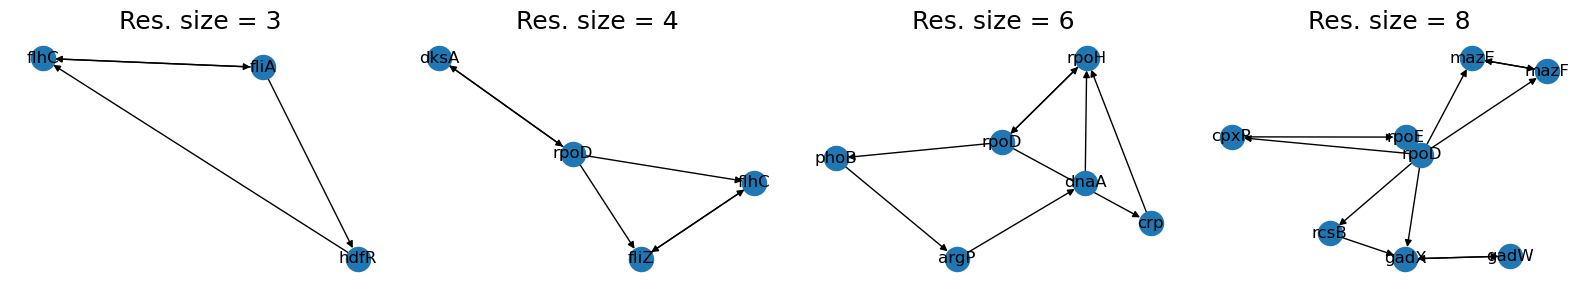

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize = (16,3), nrows=1, ncols=4)
ax = axes.flatten()


value = dict_nrnodes_list[3][1]
k = graph.subgraph(value)
H = k.copy()
H.remove_edges_from(nx.selfloop_edges(H)) 
drop_weights(H)
nx.draw_networkx(H, with_labels=True, ax=ax[0])
ax[0].set_title("Res. size = 3", fontsize=18)
ax[0].set_axis_off()

value = dict_nrnodes_list[4][20]
k = graph.subgraph(value)
H = k.copy()
H.remove_edges_from(nx.selfloop_edges(H)) 
drop_weights(H)
nx.draw_networkx(H, with_labels=True, ax=ax[1])
ax[1].set_title("Res. size = 4",fontsize=18)
ax[1].set_axis_off()

value = dict_nrnodes_list[6][15]
k = graph.subgraph(value)
H = k.copy()
H.remove_edges_from(nx.selfloop_edges(H)) 
drop_weights(H)
nx.draw_networkx(H, with_labels=True, ax=ax[2])
ax[2].set_title("Res. size = 6", fontsize=18)
ax[2].set_axis_off()

value = dict_nrnodes_list[8][9]
k = graph.subgraph(value)
H = k.copy()
H.remove_edges_from(nx.selfloop_edges(H)) 
drop_weights(H)
#nx.draw_networkx(H, with_labels=True, ax=ax[3])
nx.draw_networkx(H, pos = nx.spring_layout(H), with_labels=True, ax=ax[3])
ax[3].set_title("Res. size = 8",fontsize=18)

ax[3].set_axis_off()
plt.tight_layout()
#plt.savefig('lyapunov.png', dpi=300)
#plt.savefig('res_size.pdf')

plt.show()

In [55]:
error_mean, error_std, nr_incoherent_ffl, nr_neg_feed = np.loadtxt("data/dict3187.txt", delimiter=' ', usecols=(0, 1,2,3), unpack=True,skiprows=1)

In [56]:
nr_2_feedback, nr_selfloops = np.loadtxt("data/feedback2_selfLOOPS.txt", delimiter=' ', usecols=(0, 1), unpack=True,skiprows=1)

In [57]:
cuantas_redes = 0
nro_selfloops = []
nro_FFL = []
nro_mutual_reg = []
tamm = []


for key in dict_nrnodes_list.keys():
    for value in dict_nrnodes_list[key]:
        
        if len(value) > 2:
            k = graph.subgraph(value)
            H = k.copy()
            #H.remove_edges_from(nx.selfloop_edges(H)) 
            G2 = H.to_undirected()
            Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
            k2 = k.subgraph(Gcc[0])
            if k2.number_of_nodes() == k.number_of_nodes():
                #k = graph.subgraph(value)
                cuantosmo = nr_selfloops[cuantas_redes] 
                nro_selfloops.append(cuantosmo)
                nro_FFL.append(nr_incoherent_ffl[cuantas_redes] )
                nro_mutual_reg.append(nr_2_feedback[cuantas_redes] )
                tamm.append(len(value))
                H = k.copy()
                drop_weights(H)
                #H.remove_edges_from(nx.selfloop_edges(H)) 
                arrows = H.number_of_edges()
                noodes = H.number_of_nodes()
                
                
        cuantas_redes =cuantas_redes + 1 

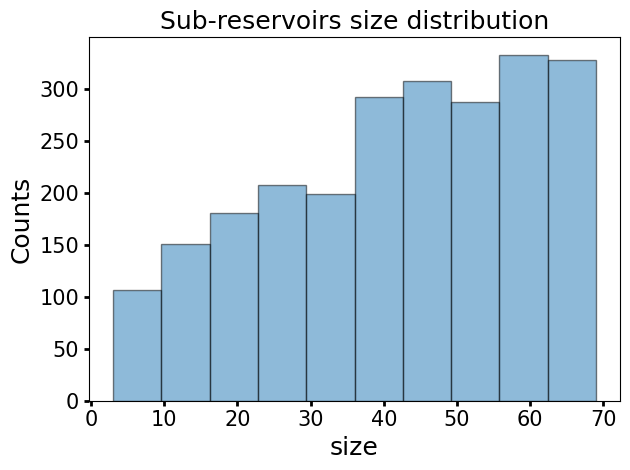

In [58]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(tamm,  density=False,  alpha=0.5, histtype='bar', ec='black')
#pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='feedback-2')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')

pyplot.xlabel("size", fontsize=18)
pyplot.ylabel("Counts", fontsize=18)
pyplot.title("Sub-reservoirs size distribution", fontsize=18)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#pyplot.savefig('size_subres_dist.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()

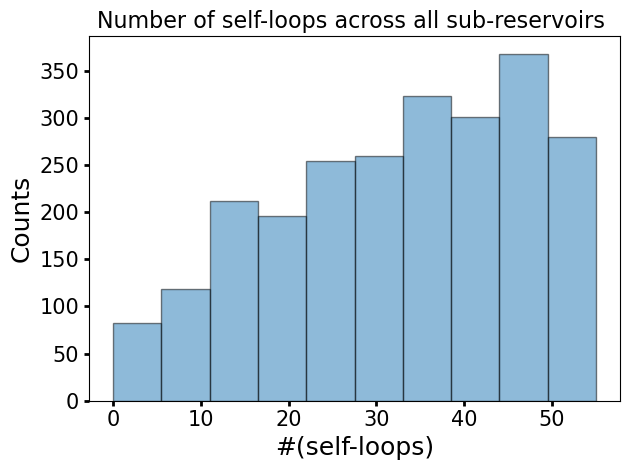

In [59]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(nro_selfloops,  density=False,  alpha=0.5, histtype='bar', ec='black')
#pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='feedback-2')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')

pyplot.xlabel("#(self-loops)", fontsize=18)
pyplot.ylabel("Counts", fontsize=18)
pyplot.title("Number of self-loops across all sub-reservoirs ", fontsize=16)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#pyplot.savefig('self_loops_dist.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()

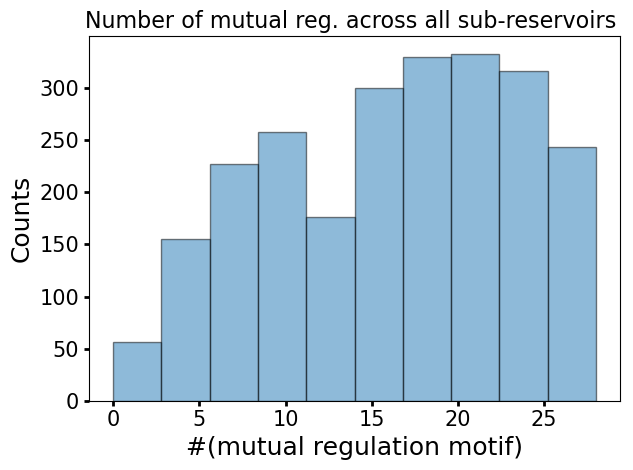

In [60]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(nro_mutual_reg,  density=False,  alpha=0.5, histtype='bar', ec='black')
#pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='feedback-2')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')

pyplot.xlabel("#(mutual regulation motif)", fontsize=18)
pyplot.ylabel("Counts", fontsize=18)
pyplot.title("Number of mutual reg. across all sub-reservoirs ", fontsize=16)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#pyplot.savefig('MUTUAL_REG_dist.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()

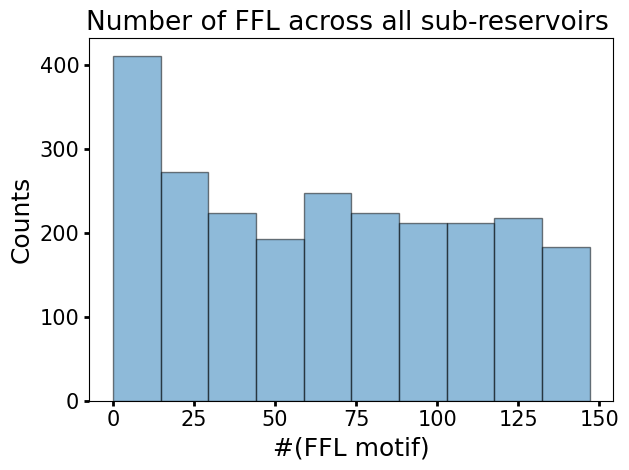

In [61]:
import random
import numpy
from matplotlib import pyplot

pyplot.hist(nro_FFL,  density=False,  alpha=0.5, histtype='bar', ec='black')
#pyplot.hist(mem_feedback2,  density=True,  alpha=0.5, label='feedback-2')
#pyplot.hist(mem_feedback2_selfloops,  alpha=0.5, label='mem_feedback2_selfloops')

pyplot.xlabel("#(FFL motif)", fontsize=18)
pyplot.ylabel("Counts", fontsize=18)
pyplot.title("Number of FFL across all sub-reservoirs ", fontsize=19)

pyplot.tick_params(width=2, axis='both', which='major', labelsize=15)
#plt.savefig('lyapunov.png', dpi=300)
#pyplot.savefig('FFL_dist.pdf',bbox_inches='tight')
pyplot.tight_layout()
pyplot.show()